In [39]:
import numpy as np
import scipy as sp
from numpy.fft import fft, ifft
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [40]:
def nls_rhs(t,ut,k):
    u=ifft(ut)
    return -(1j/2)*(k**2)*ut + 1j* fft(u*np.abs(u)**2)

In [41]:
# Nonlinear Schrodinger's Equation
def nls_solve(slices=20, L=40, n=512):
    x=np.linspace(-L/2,L/2,num=n,endpoint=False)
    k=(2*np.pi/L)*np.concatenate((np.arange(0,n/2),np.arange(-n/2,0)),axis=0)
    t=np.linspace(0,2*np.pi, slices+1)
    u = 2./np.cosh(x)
    ut = fft(u)
    sol = solve_ivp(nls_rhs, [0, 2*np.pi], ut, t_eval=t, args=[k], rtol=1e-6, atol=1e-9)
    usol=np.zeros(sol.y.shape,dtype=np.complex_)
    for j in range(len(t)):
        usol[:,j]=ifft(sol.y[:,j])
    return x,usol

In [42]:
def DMD(X, t):
    X1 = X[:, :-1]
    X2 = X[:, 1:]
    dt = t[2] - t[1]
    U, s, Vh = np.linalg.svd(X1, full_matrices=False)
    tS = U.conj().T @ X2 @ Vh.conj().T @ np.diag(1./s)
    mu, eigvec = np.linalg.eig(tS)
    omega = np.log(mu)/dt
    phi = U @ eigvec
    y0 = np.linalg.pinv(phi)@X[:, 0]
    u_modes = np.zeros((U.shape[1], len(t)),dtype='complex')
    for i in range(len(t)):
        u_modes[:,i] = y0*np.exp(omega*t[i])
    u_dmd = phi@u_modes
    return u_dmd

In [52]:
x, X = nls_solve() # small x is just domain for plotting. 
t = np.linspace(0,60*np.pi, 61)
Xdmd = DMD(X, t)

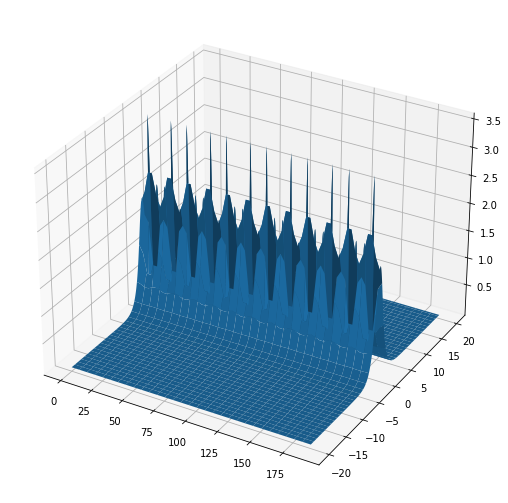

In [53]:
fig = plt.figure(figsize=(27,9))
ax = fig.add_subplot(111, projection='3d')
T, Xgr = np.meshgrid(t, x)
z = np.abs(X)
z2 = np.abs(Xdmd)

ax.plot_surface(T, Xgr, z2)

### Using less timepoints

In [43]:
# basically what it does is solve dmd with less slices, but still try to recover dmd solution in between
x, X = nls_solve() # original
x, badX = nls_solve(slices=4) # solve with less slices
t = np.linspace(0,6*np.pi, 61)
Xdmd = DMD(X, t) # good dmd sol
badXdmd = DMD(badX, t) # bad dmd sol

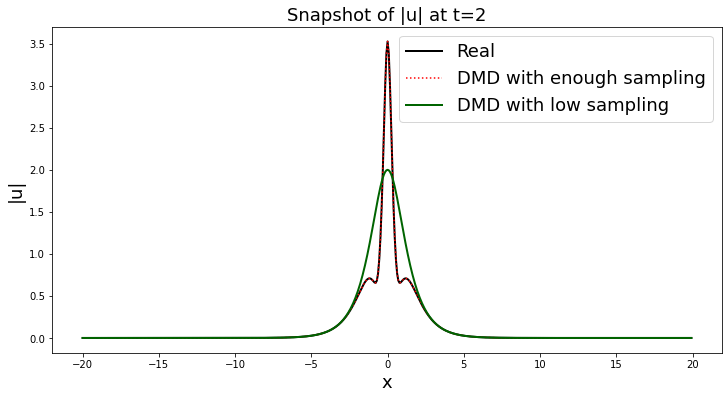

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x,np.abs(X)[:,2],label='Real', linewidth=2, c='black')
ax.plot(x,np.abs(Xdmd)[:,2],label='DMD with enough sampling', linestyle=':',c='red')
ax.plot(x,np.abs(badXdmd)[:,2],label='DMD with low sampling', c='darkgreen', linewidth=2)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('|u|', fontsize=18)
ax.set_title('Snapshot of |u| at t=2', fontsize=18)
ax.legend(fontsize=18)
#fig.savefig("lowsampplot.png")

Text(0.5, 0, 'z')

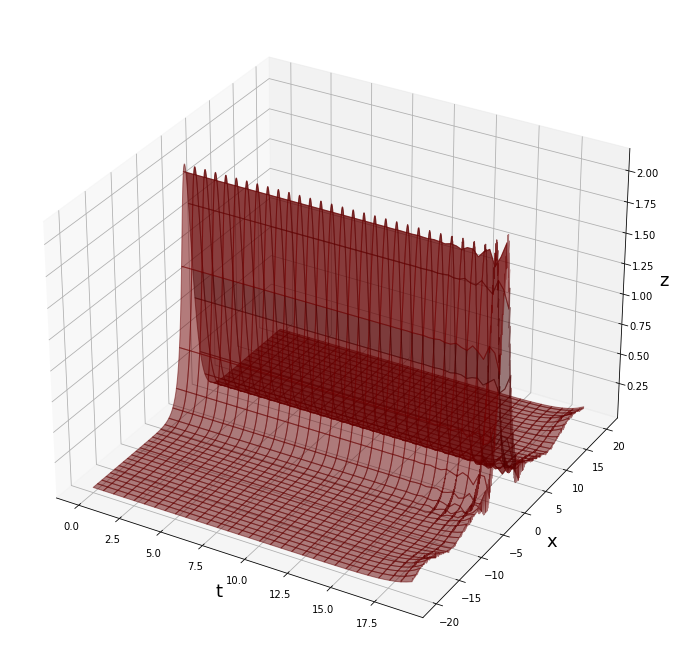

In [44]:
from matplotlib import cm

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
T, Xgr = np.meshgrid(t, x)
z = np.abs(X)
z1 = np.abs(Xdmd)
z2 = np.abs(badXdmd)
my_col = cm.jet(z2/np.amin(z2))

ax.plot_surface(T, Xgr,z2, alpha=0.5, facecolors=my_col)
ax.set_xlabel('t', fontsize=18)
ax.set_ylabel('x', fontsize=18)
ax.set_zlabel('z', fontsize=18)

#fig.savefig('Schor_lowsamp.png')

### Noisy data

In [19]:
# so this is going to sound weird but the way I generated the noise was
# 1) its complex noise so (uniform + i*uniform)
# 2) its scaled to the original sech(x) so that less noise is added at the tails 
# I thought this made more "sense" but ofc it's uneccesarily complicated.

x, X = nls_solve()
noise = np.real(X[:,0])[...,None]*(np.random.uniform(size=X.shape) + 1j*np.random.uniform(size=X.shape))
noiseX = X + noise
t = np.linspace(0,2*np.pi, 21)
Xdmd = DMD(X, t)
noiseXdmd = DMD(noiseX, t)

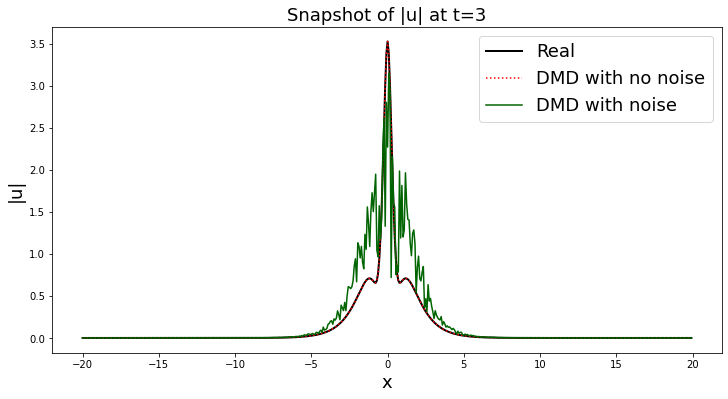

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x,np.abs(X)[:,3],label='Real', linewidth=2, c='black')
ax.plot(x,np.abs(Xdmd)[:,3],label='DMD with no noise', linestyle=':',c='red')
ax.plot(x,np.abs(noiseXdmd)[:,3],label='DMD with noise', c='darkgreen')
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('|u|', fontsize=18)
ax.set_title('Snapshot of |u| at t=3', fontsize=18)
ax.legend(fontsize=18)
#fig.savefig("noisyplot.png")

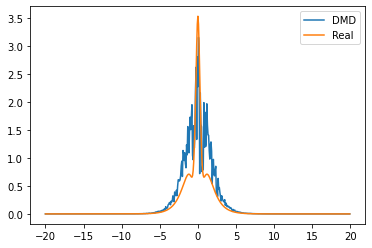

In [21]:
fig, ax = plt.subplots()
ax.plot(x,np.abs(noiseXdmd)[:,3],label='DMD')
ax.plot(x,np.abs(X)[:,2],label='Real')
ax.legend()

Text(0.5, 0, 'z')

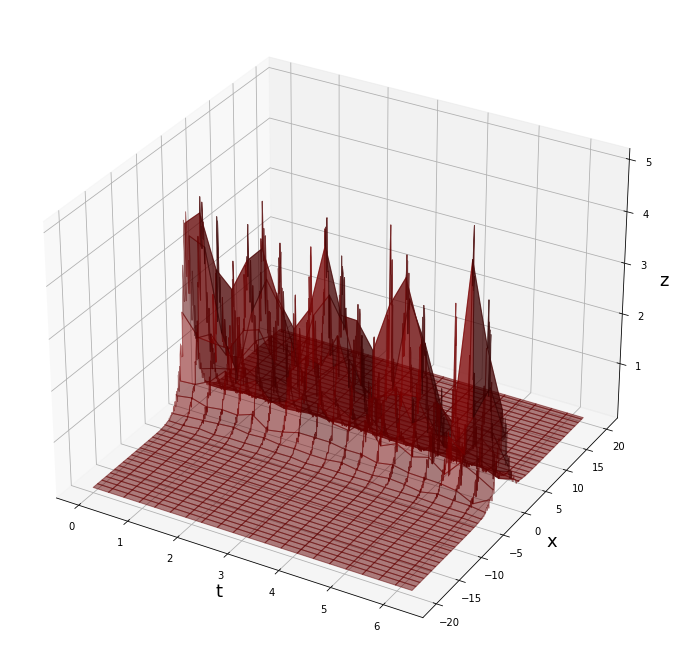

In [22]:
from matplotlib import cm

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
T, Xgr = np.meshgrid(t, x)
z = np.abs(X)
z1 = np.abs(Xdmd)
z2 = np.abs(noiseXdmd)
my_col = cm.jet(z2/np.amin(z2))

ax.plot_surface(T, Xgr,z2, alpha=0.5, facecolors=my_col)
ax.set_xlabel('t', fontsize=18)
ax.set_ylabel('x', fontsize=18)
ax.set_zlabel('z', fontsize=18)

#fig.savefig('Schor_noise.png')

### Plotting Eigenvalues

NameError: name 'mu' is not defined

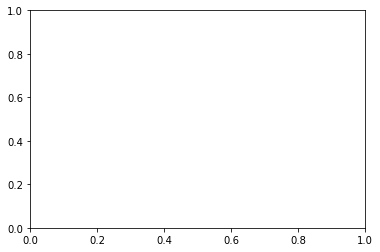

In [23]:
fig, ax = plt.subplots()
ax.scatter(np.real(mu),np.imag(mu))
t=np.linspace(0,2*np.pi, 1000)
ax.plot(np.cos(t),np.sin(t))
#ax.set_aspect('equal', adjustable='box')

In [26]:
t.shape

(1000,)

## Vorticity Data

In [3]:
vorticity = np.genfromtxt(fname='vorticity.txt')

In [4]:
vorticity.shape

(89351, 151)

In [5]:
VORT = vorticity[:,1]

In [19]:
nx = 199
ny = 449
VORT = np.real(VORT).reshape(ny,nx).T

In [20]:
VORT.shape

(199, 449)

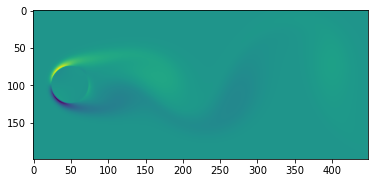

In [23]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
X, Y = np.meshgrid(x, y)
plt.imshow(VORT)

In [24]:
vortmin = -5
vortmax = 5
VORT[VORT>vortmax] = vortmax
VORT[VORT<vortmin] = vortmin

In [31]:
VORT.shape
X.shape

(449, 199)

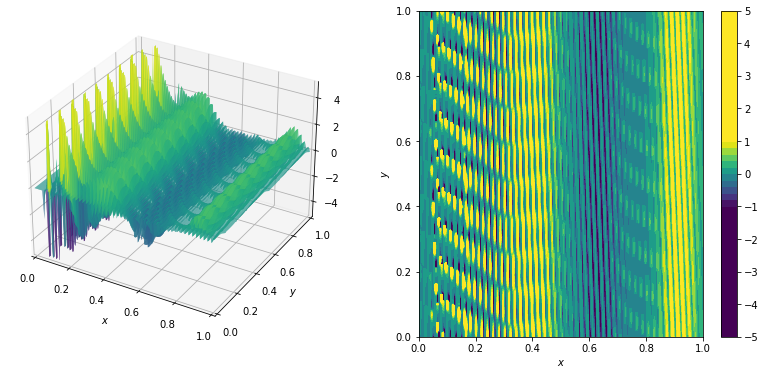

In [102]:
from matplotlib.ticker import LinearLocator

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap='viridis')
ax2 = fig.add_subplot(122)
cf = ax2.contourf(X,Y,Z,51,vmin=-1,vmax=1,cmap='viridis')
cbar = fig.colorbar(cf)
cbar.locator = LinearLocator(numticks=11)
cbar.update_ticks()
for ax in {ax1, ax2}:
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_aspect('auto')

#ax1.set_zlim([-1,1])
#ax1.set_zlabel(r'$\cos(\pi x) \sin(\p    i y)$')

plt.show()

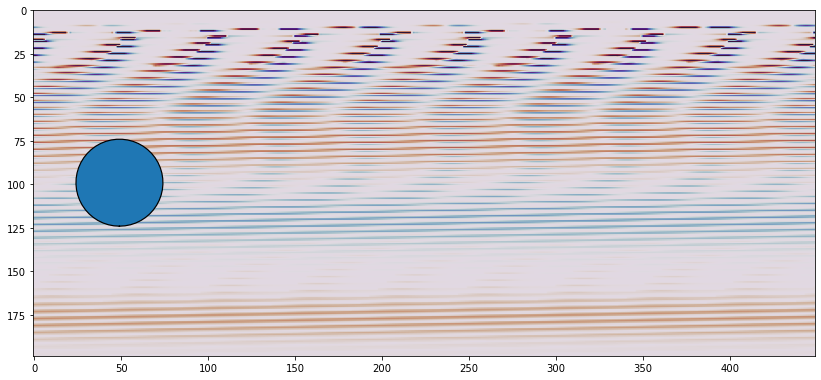

In [149]:
plt.figure(figsize=(14,10))
plt.imshow(Z, vmin=-5, vmax=5, cmap='twilight_shifted')
#plt.gca('XTick',[1 50 100 150 200 250 300 350 400 449],'XTickLabel',{'-1','0','1','2','3','4','5','6','7','8'})
#plt.gca('YTick',[1 50 100 150 199],'YTickLabel',{'2','1','0','-1','-2'})
#plt.gcf('Position',[100 100 300 130])

theta = np.linspace(0,100)/100 *2*np.pi;
x = 49+25*np.sin(theta)
y = 99+25*np.cos(theta)
plt.fill(x,y)
plt.plot(x,y,'k',linewidth=1.2)